<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Classification Metrics: ROC and AUC
              
</p>
</div>

Data Science Cohort Live NYC June 2022
<p>Phase 3: Topic 26</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

# Objectives
- Calculate and interpret probability estimates
- Visualize, calculate and interpret the AUC-ROC metric

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

#### What is the issue?

- Related to (basically the same as) concerns around Neyman-Pearson testing

<img src = "Images/neyman_small.png" width = 300 />

- $\alpha$ is the false positive rate (reject null when null is true)
- $\beta$ is false negative rate (accept null when null is false)

#### Obvious connection
- Hypothesis testing
- Probabilistic classification 

$\alpha$ and $\beta$ depends on:
- significance level
- the structure of the hypothesis test (distribution, type of test, etc.)
- the data (sample size, etc.)

Precision, recall, F-score depends on:
- threshold
- structure of model (type of model, hyperparameters)
- the data

#### Understanding model quality

Want to systematically understand:
- how changing threshold affects:
    - true positive/false positive rate
    - precision/recall 

A nice applet. Let' play with it:

http://arogozhnikov.github.io/2015/10/05/roc-curve.html

Tuning the tolerance (the significance level):
- Traces out a curve in (true positive rate, false positive rate) space.

**Reciever Operator Characteristic**

<img src = "Images/roc_curve.png" />

Reciever operator characteristic (ROC) curve:
- Name comes from early days of radar detection.
- WW2 operators detecting enemy airplanes.

<center><img src = "Images/azm_zero.jpeg" width = 500/></center>
<center> Detecting the Japanese AZM Zero Fighter </center>


#### The ROC curve in scikit-learn

In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

Load in the heart disease dataset.
[this UCI dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) 

In [3]:
hd_data = pd.read_csv('Data/heart.csv')
hd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
# Separate data into feature and target DataFrames
hd_X = hd_data.drop('target', axis=1)
hd_y = hd_data['target']
hd_X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [5]:
hd_y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [6]:
hd_y.value_counts() # 1 = heart disease

1    165
0    138
Name: target, dtype: int64

In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(hd_X, hd_y, test_size=.25,
                                                   random_state=1)
# Scale the data for modeling, scaling needs to be done because the model is regularized?
hd_scaler = StandardScaler()
hd_scaler.fit(X_train)
X_train_sc = hd_scaler.transform(X_train)
X_test_sc = hd_scaler.transform(X_test)

# Train a logistic regresssion model with the train data
hd_model = LogisticRegression(random_state=42)
hd_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

In [8]:
y_pred = hd_model.predict(X_test_sc)
y_pred[:10]

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

Scikit-learn assumes a probability threshold of 0.5 on binary classification.

<center><img src = "Images/sigmoid.png" /></center>

#### The underlying predicted probability of each class given data observation
- the .predict_proba() function

In [9]:
y_prob = hd_model.predict_proba(X_test_sc)
y_prob[:5]

array([[0.99583439, 0.00416561],
       [0.2234686 , 0.7765314 ],
       [0.91939062, 0.08060938],
       [0.99402865, 0.00597135],
       [0.97047813, 0.02952187]])

Get a 2D array:
- [P(class 0|x), P(class 1|x)] for each x in test set.

In principle:
- Can change threshold cutoff to assign to given class
- Track changes in metrics
    - True positive/false positive rate
    - Precision/recall

#### roc_curve(y_true, y_score)
- first argument: test values
- second argument: probability of positive class    

- list of false positive rate (fpr)
- list of true positive rate (tpr)
- list of "thresholds" each fpr, tpr was calculated at:
    - actually values of decision function

### True Positive Rate
True Positive Rate (TPR) is the same as recall, measuring how many of the positive cases we correctly classified as positive.

**True Positive Rate (TPR)** = **Recall** = $\frac{TP}{TP + FN}$


### False Positive Rate
False Positive Rate (FPR) measures how many of the negative casses we incorrectly classified as positive.

**False Positive Rate (TPR)** = $\frac{FP}{FP + TN}$

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

In [11]:
tpr 

array([0.        , 0.02439024, 0.3902439 , 0.3902439 , 0.46341463,
       0.46341463, 0.53658537, 0.53658537, 0.6097561 , 0.6097561 ,
       0.65853659, 0.65853659, 0.68292683, 0.68292683, 0.70731707,
       0.70731707, 0.80487805, 0.80487805, 0.87804878, 0.87804878,
       0.90243902, 0.90243902, 0.97560976, 0.97560976, 1.        ,
       1.        ])

In [12]:
fpr

array([0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.08571429, 0.08571429, 0.11428571, 0.11428571, 0.17142857,
       0.17142857, 0.2       , 0.2       , 0.25714286, 0.25714286,
       0.28571429, 0.28571429, 0.31428571, 0.31428571, 0.34285714,
       0.34285714, 0.42857143, 0.42857143, 0.51428571, 0.51428571,
       1.        ])

Probably more useful/used:
- plot ROC curve

C:\Users\harri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


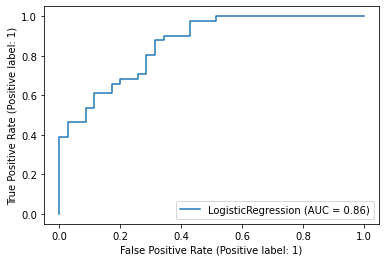

In [13]:
plot_roc_curve(hd_model, X_test_sc, y_test)

Lowering detection threshold:
-  If I raise significance level, lower detection threshold:
    - get more true positives
    - also get more false negatives
- Extreme case:
    - detects everything as positive class

C:\Users\harri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


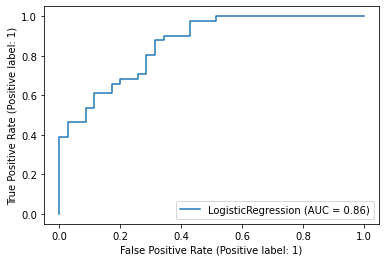

In [14]:
plot_roc_curve(hd_model, X_test_sc, y_test)

What does this have to do with model quality?
- Hope is that as we change threshold
- Can create models that typically have:
    - higher TPR vs. FPRs

Good model vs bad models

<center><img src = "Images/Roc_curves_better.png" /></center>

What affects the ROC curve?

That applet again.

http://arogozhnikov.github.io/2015/10/05/roc-curve.html

Making good models are reflected in ROC curve structure:

- Use good distribution/function for data modeling
    - Model selection (logistic regression, tree model, etc.)
    - Feature Engineering

- Decrease model variance
    - Regularization
    - Get more data

Gives our ROC curve more downward L-shaped

> Remember: If my test data comprises 90% positives and only 10% negatives, then a simple classifier that always predicts "positive" will be 90% accurate! And so that would be the baseline level for a classifier on that data.

# Oversampling

What do you do if your model doesn't perform well due to class imbalance? One of the most effective strategies is to **oversample the minority class**. That is, I give myself more data points than I really have. I could achieve this either by [bootstrapping](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) or by generating some data that is fake but close to actual data. The latter is the idea behind [SMOTE](https://imbalanced-learn.org/stable/over_sampling.html).

#### ROC-AUC score

Gets the area under the ROC curve (AUC):
- Measure of model and/or data quality
- Bad model: AUC ~ 0.5 (area of triangle)
- Good model: AUC $\rightarrow$ 1

<center><img src = "images/auc.png" width = 300 /></center>

<center><img src = "Images/Roc_curves_better.png" /></center>

In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
# Extract the probabilitiy predictions for the "1" class (heart disease)
y_hat_hd = y_prob[:, 1]

roc_auc_score(y_test, y_hat_hd)

0.8606271777003485

# Scenario: Breast Cancer Prediction
Let's evaluate a model using Scikit-Learn's breast cancer dataset:

In [17]:
from sklearn.datasets import load_breast_cancer
# Load the data
preds, target = load_breast_cancer(return_X_y=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(preds, target,
                                                   random_state=42)

# Scale the data
bc_scaler = StandardScaler()
bc_scaler.fit(X_train)
X_train_sc = bc_scaler.transform(X_train)
X_test_sc = bc_scaler.transform(X_test)

# Run the model
bc_model = LogisticRegression(solver='lbfgs', max_iter=10000,
                           random_state=42)
bc_model.fit(X_train_sc, y_train)

LogisticRegression(max_iter=10000, random_state=42)

## Task

For this example, draw the ROC curve and calculate the AUC-ROC metric. Based on the results, do you think your model would be useful for identifying patients with breast cancer?

C:\Users\harri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.9795047856845609

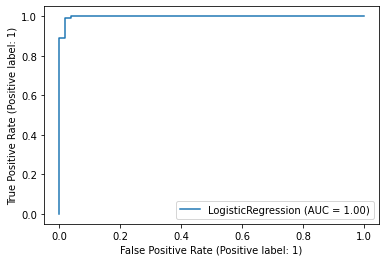

In [18]:
plot_roc_curve(bc_model, X_test_sc, y_test)
roc_auc_score(y_test, bc_model.predict(X_test_sc))

# Loss Functions
Another more "natural" way of measuring the quality of a classifier is just to look at the loss function, which will often be the **log loss**. In multiclass problems, we use **cross-entropy loss**. 

In [19]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [76, 143]

While such loss values are difficult to interpret on their own, they are useful for comparing models. Models with lower loss values generate probability estimates that are closer to the true values, and thus are likely to perform better on many metrics